<a href="https://colab.research.google.com/github/viyamKUN/ae-web-demo/blob/main/train_autoencoder_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training AutoEncoder Model in TensorFlow

TensorFlow를 이용한 간단한 AutoEncoder 학습.

In [1]:
import time
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

## Prepare data

color 이미지 중, width와 height가 동일한 dataset으로 학습과 테스트를 진행한다. 이미지는 0~1의 float값으로 매핑하고 32 크기의 batch로 나누어 사용한다.

In [2]:
[train_ds, test_ds], ds_info = tfds.load('cifar100', split=['train', 'test'], shuffle_files=True, with_info=True)

print('train_ds:', train_ds)
print('test_ds:', test_ds)
print(ds_info)

def map_fn(x: tf.Tensor) -> Tuple[tf.Tensor, tf.Tensor]:
  image = x['image']
  image = tf.cast(image, tf.float32)
  image /= 256.0
  return image, image

train_ds = (
    train_ds
    .shuffle(ds_info.splits['train'].num_examples, reshuffle_each_iteration=True)
    .map(map_fn)
    .batch(32)
)

test_ds = (
    test_ds
    .map(map_fn)
    .batch(32)
)

print(train_ds.element_spec)
print(test_ds.element_spec)

train_ds: <PrefetchDataset element_spec={'coarse_label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
test_ds: <PrefetchDataset element_spec={'coarse_label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>
tfds.core.DatasetInfo(
    name='cifar100',
    full_name='cifar100/3.0.2',
    description="""
    This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the super

## Define model



In [3]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
              tf.keras.layers.Conv2D(32, 3, padding='same', data_format='channels_last'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(latent_dim, activation='relu'),
            ],
            name='encoder',
        )
        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(3072, activation='sigmoid'),
                tf.keras.layers.Reshape((32, 32, 3))
            ],
            name='decoder',
        )

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Train model

In [4]:
latent_dim = 196
model = Autoencoder(latent_dim)
model(tf.keras.Input((32, 32, 3)))
model.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 196)               6423620   
                                                                 
 decoder (Sequential)        (None, 32, 32, 3)         605184    
                                                                 
Total params: 7,028,804
Trainable params: 7,028,804
Non-trainable params: 0
_________________________________________________________________


In [5]:
model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
model.fit(train_ds,
          epochs=10,
          validation_data=test_ds)

Epoch 1/10
1563/1563 [==============================] - 25s 9ms/step - loss: 0.0173 - val_loss: 0.0113
Epoch 2/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0098 - val_loss: 0.0091
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0084 - val_loss: 0.0080
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0067 - val_loss: 0.0066
Epoch 6/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0061 - val_loss: 0.0060
Epoch 7/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.0058 - val_loss: 0.0060
Epoch 8/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0056 - val_loss: 0.0057
Epoch 9/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 10/10
1563/1563 [==============================] - 9s 5ms/step - loss: 0.00

## Visualize results

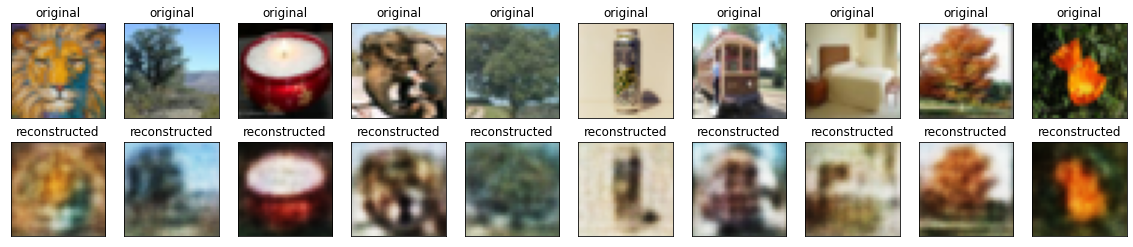

In [6]:
img_for_plot, _ = next(iter(test_ds))

encoded_imgs = model.encoder(img_for_plot).numpy()
decoded_imgs = model.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(img_for_plot[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Save model

In [7]:
model.save(f"./model/{int(time.time())}/", include_optimizer=False)

INFO:tensorflow:Assets written to: ./model/1660137036/assets


INFO:tensorflow:Assets written to: ./model/1660137036/assets
